# Creating a sea ice mask for CM2.6

I spent almost a day to work this out. 

The issue at hand seems resonably simple: Upsample the monthly `melt` field to daily and use it as a proxy for sea ice.

In practice this seems to be a really gnarly problem: 
- ...

What I have done here is simpley to get a 💩ton of memory and persist the whole thing....

Not really a great solution, but we need this ice mask, so whatever

In [1]:
from scale_aware_air_sea.utils import open_zarr
from scale_aware_air_sea.parameters import get_params
import numpy as np
import gcsfs
import matplotlib.pyplot as plt
import cftime
import xarray as xr

# Need to get a lot of memory here
3TB worked, lets see if we can do a little less though 

- 400GB is not enough
- 800GB is not enough
- 1.6TB is barely working (lots of spilling), but it succeeded

In [2]:
import dask
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options = gateway.cluster_options()
# options.worker_memory = 32
options.worker_memory = 16

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.scale(100) #400GB total ram
client

[ClusterReport<name=prod.2b35c30a5658404e91c6ecd6d937ce96, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.a29cbece75fd4b8ca9a608f4b930ccdf/status,


In [3]:
# load global parameters
params = get_params('v0.7.0', test=False) 

fs = gcsfs.GCSFileSystem()

mapper_online_flux = fs.get_mapper('gs://cmip6/GFDL_CM2_6/control/ocean_boundary')
mapper_offline_flux = fs.get_mapper(params['paths']['CM26']['filter_fluxes'])
mapper_ice = fs.get_mapper(params['paths']['CM26']['ice_mask'])

ds_online = open_zarr(mapper_online_flux)
ds_offline = open_zarr(mapper_offline_flux)

## Pad the edges of the melt array

In [4]:
# creating a time resolved ice mask
melt = ds_online.melt

melt_padded = melt.pad(pad_width={'time':1}, mode='edge')
# replace the time with properly padded values
padded_time = np.hstack([
    np.array([cftime.DatetimeJulian(180, 12, 15, 12, 0, 0)]),
    melt.time.data,
    np.array([cftime.DatetimeJulian(201, 1, 16, 12, 0, 0)])
])
melt_padded = melt_padded.assign_coords(time=padded_time)
melt_padded

<xarray.DataArray 'melt' (time: 242, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<concatenate, shape=(242, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * time      (time) object 0180-12-15 12:00:00 ... 0201-01-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    long_name:      water flux transferred with sea ice form/melt (>0 enters ...
    standard_name:  water_flux_into_sea_water_due_to_sea_ice_thermodynamics
    time_avg_info:  average_T1,average_T2,average_DT
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.0, 1000000.0]

### the most horrible way to do this! Get a ton of workers and load the full thing into memory...

In [5]:
melt_padded_rechunked = melt_padded.chunk({'time':-1, 'xt_ocean':10}).persist() # this is fairly small

## interpolate the time

In [7]:
melt_interpolated = melt_padded_rechunked.interp(time=ds_offline.time)
melt_interpolated

<xarray.DataArray 'melt' (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(7305, 2700, 3600), dtype=float32, chunksize=(7305, 2700, 10), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 10), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 10), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Attributes:
    cell_methods:   time: mean
    long_name:      water flux transferred with sea ice form/melt (>0 enters ...
    standard_name:  water_flux_into_sea_water_due_to_sea_ice_thermodynamics
    time_avg_info:  average_T1,average_T2,average_DT
    units:          (kg/m^3)*(m/sec)
    valid_range:    [-1000000.0, 1000000.0]

### Can I do this on the fly?

In [8]:
# write out *AGAIN*
melt_interpolated.to_dataset(name='melt').chunk({'time':3, 'xt_ocean':-1}).to_zarr(mapper_ice, mode='w')

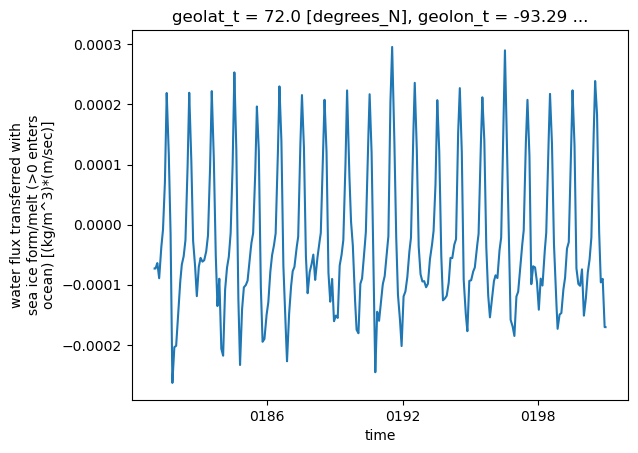

In [9]:
ds_test2 = xr.open_dataset(mapper_ice, engine='zarr', chunks={})
ds_test2.melt.isel(xt_ocean=2000, yt_ocean=2600).plot()

In [10]:
cluster.shutdown()